In [1]:
import json

import pandas as pd
import numpy as np

import datetime as dt
from datetime import datetime, date

import seaborn as sns
import matplotlib.pyplot as plt

from sympy.interactive import printing
printing.init_printing(use_latex=True)
from sympy import Eq, solve_linear_system, Matrix
from numpy import linalg
import sympy as sp

import warnings
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None #catch SettingCopyWarning

import functools as ft
import dataframe_image as dfi

json_file_path = "/Users/aianellenado/Documents/ITMGT25/ad-hoc/transaction-data-adhoc-analysis.json"
    
df = pd.read_json (r'/Users/aianellenado/Documents/ITMGT25/ad-hoc/transaction-data-adhoc-analysis.json')

In [2]:
# convert transaction date from string to datetime value
df['transaction_date']= pd.to_datetime(df['transaction_date'])
# extract transaction month and convert to month name
df['Transaction Month'] = pd.to_datetime(df['transaction_date']).dt.month
df['Transaction Month'] = pd.to_datetime(df['Transaction Month'], format='%m').dt.month_name()
df[['Transaction Month','transaction_items','transaction_value']]
# split transaction_items
df[['Item1', 'Item2', 'Item3']] = df['transaction_items'].str.split(';', expand=True)
# split item 1
df[['Item1_Name1', 'Item1_Name2', 'Item1_Q']] = df['Item1'].str.split(',', expand=True)
# split item 2
df[['Item2_Name1', 'Item2_Name2', 'Item2_Q']] = df['Item2'].str.split(',', expand=True)
# split item 3
df[['Item3_Name1', 'Item3_Name2', 'Item3_Q']] = df['Item3'].str.split(',', expand=True)
# concat item 1
df['Item 1'] = df['Item1_Name1']+ ', ' + df['Item1_Name2']
# concat item 2
df['Item 2'] = df['Item2_Name1']+ ', ' + df['Item2_Name2']
# concat item 3
df['Item 3'] = df['Item3_Name1']+ ', ' + df['Item3_Name2']

# convert null values to 0 
df['Item2_Q2'] = df['Item2_Q'].fillna('0')
df['Item3_Q2'] = df['Item3_Q'].fillna('0')

# extract the integer values in each transaction that represents the quantity sold
def convert_items (y):
    charset = [*[str(i) for i in range(10)]]
    y = ','.join([x for x in y if x in charset])
    return int(y)

df['Item 1 Quantity'] = df['Item1_Q'].apply(convert_items)
df['Item 2 Quantity'] = df['Item2_Q2'].apply(convert_items)
df['Item 3 Quantity'] = df['Item3_Q2'].apply(convert_items)

df_clean = df[['transaction_date','Transaction Month','name','username','birthdate','sex','Item 1','Item 1 Quantity','Item 2','Item 2 Quantity','Item 3','Item 3 Quantity','transaction_value']]

df_clean

,transaction_date,Transaction Month,name,username,birthdate,sex,Item 1,Item 1 Quantity,Item 2,Item 2 Quantity,Item 3,Item 3 Quantity,transaction_value
0,2022-01-12,January,Jennifer Campbell,veronicawells,1926/03/11,F,"Exotic Extras, Beef Chicharon",4,NaN,0,NaN,0,5196
1,2022-01-12,January,Melissa Kim,cgilbert,2016/07/08,F,"Exotic Extras, Beef Chicharon",3,"HealthyKid 3+, Nutrional Milk",4,"Candy City, Orange Beans",1,12056
2,2022-01-08,January,Melissa Kim,cgilbert,2016/07/08,F,"HealthyKid 3+, Gummy Vitamins",3,"HealthyKid 3+, Yummy Vegetables",2,NaN,0,5500
3,2022-01-10,January,Melissa Kim,cgilbert,2016/07/08,F,"HealthyKid 3+, Yummy Vegetables",1,NaN,0,NaN,0,500
4,2022-01-24,January,Kristen Cooper,qhernandez,1949/09/27,F,"Candy City, Orange Beans",3,"Candy City, Gummy Worms",4,"HealthyKid 3+, Gummy Vitamins",1,2697
...,...,...,...,...,...,...,...,...,...,...,...,...,...
83031,2022-06-05,June,Tammy Byrd,kmcconnell,2019/10/26,F,"Exotic Extras, Kimchi and Seaweed",2,"HealthyKid 3+, Nutrional Milk",1,NaN,0,3588
83032,2022-06-12,June,Donald Andersen,llowe,1913/11/04,M,"HealthyKid 3+, Yummy Vegetables",1,"Exotic Extras, Kimchi and Seaweed",1,"Candy City, Orange Beans",4,2095
83033,2022-06-15,June,Donald Andersen,llowe,1913/11/04,M,"Candy City, Orange Beans",4,"Candy City, Gummy Worms",4,"HealthyKid 3+, Yummy Vegetables",4,3396
83034,2022-06-09,June,Donald Andersen,llowe,1913/11/04,M,"HealthyKid 3+, Nutrional Milk",2,"Candy City, Gummy Worms",2,NaN,0,4280


# Breakdown of Count of Each Item per Month

In [3]:
# create table of total quantity sold for Item 1
item1_quantity = df_clean.groupby(['Transaction Month','Item 1'],sort=False)[['Item 1 Quantity']].sum().reset_index()
item1_quantity.rename(columns = {'Item 1':'Item Name'}, inplace=True)
item1_quantity = item1_quantity.sort_values(by=['Transaction Month','Item Name'], ascending=True)
item1_quantity['Month|Item Name'] = item1_quantity['Transaction Month']+'|'+item1_quantity['Item Name']
item1_quantity = item1_quantity[['Month|Item Name', 'Item 1 Quantity']]
item1_quantity = item1_quantity.reset_index(drop=True)

# create table of total quantity sold for Item 2
item2_quantity = df_clean.groupby(['Transaction Month','Item 2'],sort=False)[['Item 2 Quantity']].sum().reset_index()
item2_quantity.rename(columns = {'Item 2':'Item Name'}, inplace=True)
item2_quantity = item2_quantity.sort_values(by=['Transaction Month','Item Name'], ascending=True)
item2_quantity['Month|Item Name'] = item2_quantity['Transaction Month']+'|'+item2_quantity['Item Name']
item2_quantity = item2_quantity[['Month|Item Name', 'Item 2 Quantity']]
item2_quantity = item2_quantity.reset_index(drop=True)

# create table of total quantity sold for Item 3
item3_quantity = df_clean.groupby(['Transaction Month','Item 3'],sort=False)[['Item 3 Quantity']].sum().reset_index()
item3_quantity.rename(columns = {'Item 3':'Item Name'}, inplace=True)
item3_quantity = item3_quantity.sort_values(by=['Transaction Month','Item Name'], ascending=True)
item3_quantity['Month|Item Name'] = item3_quantity['Transaction Month']+'|'+item3_quantity['Item Name']
item3_quantity = item3_quantity[['Month|Item Name', 'Item 3 Quantity']]
item3_quantity = item3_quantity.reset_index(drop=True)

# merged the three tables for generated above to create a summary table for the total quantity sold per item
items_quantity = [item1_quantity, item2_quantity, item3_quantity]
items_quantity_final = ft.reduce(lambda left, right: pd.merge(left, right, on='Month|Item Name'), items_quantity)
items_quantity_final['Total Quantity Sold'] = items_quantity_final['Item 1 Quantity'] + items_quantity_final['Item 2 Quantity'] + items_quantity_final['Item 3 Quantity']
items_quantity_final[['Transaction Month','Item Name']] = items_quantity_final['Month|Item Name'].str.split('|', expand=True)
quantity_per_item = items_quantity_final[['Transaction Month', 'Item Name', 'Total Quantity Sold']]

# assigned values to each month using mappingfor sorting
month_map = {'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6}
quantity_per_item['Month Number'] = quantity_per_item['Transaction Month'].apply(lambda Transaction_Month: month_map[Transaction_Month])
quantity_per_item = quantity_per_item.sort_values(by=['Month Number', 'Item Name'], axis=0)
quantity_per_item = quantity_per_item.drop(columns='Month Number').reset_index(drop=True)
quantity_per_item

,Transaction Month,Item Name,Total Quantity Sold
0,January,"Candy City, Gummy Worms",9559
1,January,"Candy City, Orange Beans",9774
2,January,"Exotic Extras, Beef Chicharon",9665
3,January,"Exotic Extras, Kimchi and Seaweed",9676
4,January,"HealthyKid 3+, Gummy Vitamins",9681
5,January,"HealthyKid 3+, Nutrional Milk",9727
6,January,"HealthyKid 3+, Yummy Vegetables",9959
7,February,"Candy City, Gummy Worms",9996
8,February,"Candy City, Orange Beans",10037
9,February,"Exotic Extras, Beef Chicharon",10001


In [4]:
dfi.export(quantity_per_item, "213524-Llenado_Breakdown of Count of Each Item per Month.png")

objc[2189]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x7ffb4b878ec8) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/103.0.5060.134/Libraries/libGLESv2.dylib (0x115af8d18). One of the two will be used. Which one is undefined.
[0724/124953.771400:INFO:headless_shell.cc(660)] Written to file /var/folders/rf/ryzltj3n041dfr_8hm5_wgyc0000gn/T/tmpiau2sgta/temp.png.
objc[2202]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x7ffb4b878ec8) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/103.0.5060.134/Libraries/libGLESv2.dylib (0x112061d18). One of the two will be used. Which one is undefined.
[0724/124957.539624:INFO:headless_shell.cc(6

# Breakdown of Total Sale Value per Item per Month

In [5]:
# Use Sympy to solve the cost per item
eq_jan1 = sp.Function('eq_jan1')
eq_jan2 = sp.Function('eq_jan2')
eq_jan3 = sp.Function('eq_jan3')
eq_jan4 = sp.Function('eq_jan4')
eq_jan5 = sp.Function('eq_jan5')
eq_jan6 = sp.Function('eq_jan6')
eq_jan7 = sp.Function('eq_jan7')

BC, NM, OB, GV, YV, GW, KS = sp.symbols('BC NM OB GV YV GW KS')

eq1_jan = Eq(4*BC, 5196) 
eq2_jan = Eq(3*BC + 4*NM + OB, 12056)
eq3_jan = Eq(3*GV + 2*YV, 5500)
eq4_jan = Eq(YV, 500)
eq5_jan = Eq(3*OB + 4*GW + GV, 2697)
eq6_jan = Eq(NM + 2*YV, 2990)
eq7_jan = Eq(4*KS, 3196)

row1_jan = [4,0,0,0,0,0,0,5196]
row2_jan = [3,4,1,0,0,0,0,12056]
row3_jan = [0,0,0,3,2,0,0,5500]
row4_jan = [0,0,0,0,1,0,0,500]
row5_jan = [0,0,3,1,0,4,0,2697]
row6_jan = [0,1,0,0,2,0,0,2990]
row7_jan = [0,0,0,0,0,0,4,3196]

system = Matrix((row1_jan, row2_jan, row3_jan, row4_jan, row5_jan, row6_jan, row7_jan))

display(eq1_jan)
display(eq2_jan)
display(eq3_jan)
display(eq4_jan)
display(eq5_jan)
display(eq6_jan)
display(eq7_jan)

display(system)

item_cost = solve_linear_system(system, BC, NM, OB, GV, YV, GW, KS)
item_cost

⎡4  0  0  0  0  0  0  5196 ⎤
⎢                          ⎥
⎢3  4  1  0  0  0  0  12056⎥
⎢                          ⎥
⎢0  0  0  3  2  0  0  5500 ⎥
⎢                          ⎥
⎢0  0  0  0  1  0  0   500 ⎥
⎢                          ⎥
⎢0  0  3  1  0  4  0  2697 ⎥
⎢                          ⎥
⎢0  1  0  0  2  0  0  2990 ⎥
⎢                          ⎥
⎣0  0  0  0  0  0  4  3196 ⎦

In [6]:
# assign variable names to the items through mapping
item_dict = {'Exotic Extras, Beef Chicharon': 'BC', 'HealthyKid 3+, Gummy Vitamins': 'GV', 'HealthyKid 3+, Yummy Vegetables': 'YV', 'Candy City, Orange Beans': 'OB','HealthyKid 3+, Nutrional Milk': 'NM',
'Exotic Extras, Kimchi and Seaweed': 'KS', 'Candy City, Gummy Worms': 'GW'}
quantity_per_item['Item Variable Name'] = quantity_per_item['Item Name'].map(item_dict).fillna('X')

# assign item costs to the variable names through mapping 
Item_Cost = {'BC': 1299, 'GV': 1500, 'GW': 150, 'KS': 799, 'NM': 1990, 'OB': 199, 'YV': 500}
quantity_per_item['Item Cost'] = quantity_per_item['Item Variable Name'].map(Item_Cost)

# multiply the values under Item Cost and Total Quantity Sold per Item
quantity_per_item['Total Sale Value'] = quantity_per_item['Item Cost']*quantity_per_item['Total Quantity Sold']
total_sale_value = quantity_per_item[['Transaction Month', 'Item Name', 'Item Cost', 'Total Quantity Sold', 'Total Sale Value']]
total_sale_value = total_sale_value.reset_index(drop=True)
total_sale_value

,Transaction Month,Item Name,Item Cost,Total Quantity Sold,Total Sale Value
0,January,"Candy City, Gummy Worms",150,9559,1433850
1,January,"Candy City, Orange Beans",199,9774,1945026
2,January,"Exotic Extras, Beef Chicharon",1299,9665,12554835
3,January,"Exotic Extras, Kimchi and Seaweed",799,9676,7731124
4,January,"HealthyKid 3+, Gummy Vitamins",1500,9681,14521500
5,January,"HealthyKid 3+, Nutrional Milk",1990,9727,19356730
6,January,"HealthyKid 3+, Yummy Vegetables",500,9959,4979500
7,February,"Candy City, Gummy Worms",150,9996,1499400
8,February,"Candy City, Orange Beans",199,10037,1997363
9,February,"Exotic Extras, Beef Chicharon",1299,10001,12991299


In [7]:
dfi.export(total_sale_value, "213524-Llenado_Breakdown of Total Sale Value per Item per Month.png")

objc[2214]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x7ffb4b878ec8) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/103.0.5060.134/Libraries/libGLESv2.dylib (0x106a5fd18). One of the two will be used. Which one is undefined.
[0724/125005.111850:INFO:headless_shell.cc(660)] Written to file /var/folders/rf/ryzltj3n041dfr_8hm5_wgyc0000gn/T/tmpwv6613dt/temp.png.
objc[2224]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x7ffb4b878ec8) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/103.0.5060.134/Libraries/libGLESv2.dylib (0x10f0a5d18). One of the two will be used. Which one is undefined.
[0724/125009.227330:INFO:headless_shell.cc(6

## Total Quantity Sold and Cost per Item Graph

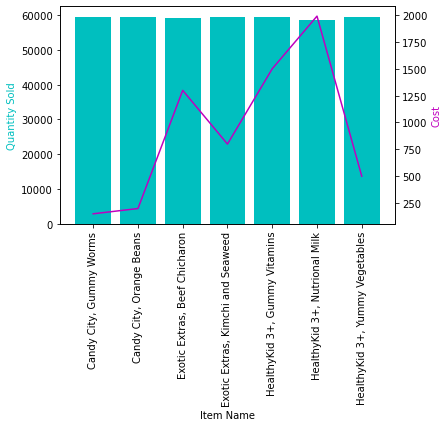

In [39]:
# used Item Name as label for x axis
# create a graph comparing the Total Quantity Sold and Cost per Item based on the values from total_sale_value

item_group = total_sale_value.groupby('Item Name')
quantity_sold = item_group.sum()['Total Quantity Sold']
items = [item for item, df in item_group]

cost = total_sale_value.groupby('Item Name').mean()['Item Cost']

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.bar(items, quantity_sold, color = 'c')
ax2.plot(items, cost, 'm-')

ax1.set_xlabel('Item Name')
ax1.set_ylabel('Quantity Sold', color = 'c')
ax2.set_ylabel('Cost', color = 'm')
ax1.set_xticklabels(items, rotation = 'vertical', size = 10)

quantity_cost_graph = plt.gcf()
plt.show()

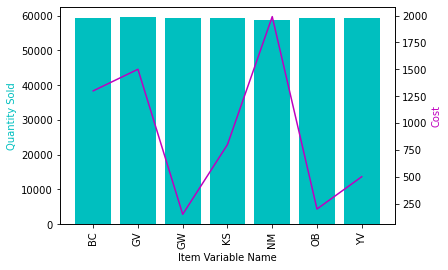

In [9]:
# used Item Variable Name as label for x axis
# create a graph comparing the Total Quantity Sold and Cost per Item based on the values from total_sale_value

total_sale_value_var = quantity_per_item[['Transaction Month', 'Item Name', 'Item Variable Name', 'Item Cost', 'Total Quantity Sold', 'Total Sale Value']]
total_sale_value_var = total_sale_value_var.reset_index(drop=True)

item_group_var = total_sale_value_var.groupby('Item Variable Name')
quantity_sold_var = item_group_var.sum()['Total Quantity Sold']
items_var = [item_var for item_var, df in item_group_var]

cost_var = total_sale_value_var.groupby('Item Variable Name').mean()['Item Cost']

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.bar(items_var, quantity_sold_var, color = 'c')
ax2.plot(items_var, cost_var, 'm-')

ax1.set_xlabel('Item Variable Name')
ax1.set_ylabel('Quantity Sold', color = 'c')
ax2.set_ylabel('Cost', color = 'm')
ax1.set_xticklabels(items_var, rotation = 'vertical', size = 10)

quantity_cost_graph_var = plt.gcf()
plt.show()
quantity_cost_graph_var.savefig('213524-Llenado_Total Quantity Sold and Cost per Item Graph.png', dpi=200)

# Repeaters, Inactive and Engaged Metric

In [10]:
# extract transaction date, name and transaction month 
customer_activity = df_clean[['transaction_date','name','Transaction Month']]
# drop the other transactions of each customer in the same month and only consider the latest transaction per month
customer_activity = customer_activity.drop_duplicates(subset = ['name','Transaction Month'], keep = 'last').reset_index(drop = True)

# generate a truth table to indicate whether or not the customer purchased item/s in a certain month
transaction_truth_table = customer_activity.groupby(['name', 'Transaction Month'],sort=False).size().unstack(fill_value=0).astype(bool)
# create a summary of the truth values per customer using lists
transaction_truth_table_list = transaction_truth_table.values.tolist()
truth_value_summary = pd.DataFrame({'Truth Values Summary': transaction_truth_table_list})

# define functions to count the number of repeaters, inactive and engaged customers
def rep(x):
    customers_repeaters = []
    for j in range(6):
        if j == 0:
            customers_repeaters.append(0)
        elif x[j] == True and x[j-1] == True:
            customers_repeaters.append(1)
        elif x[j] == True and x[j-1] == False:
            customers_repeaters.append(0)
        elif x[j] == False or x[j-1] == False:
            customers_repeaters.append(0)
    return customers_repeaters

def ina(x):
    customers_inactive = []
    for j in range(6):
        if j == 0:
            customers_inactive.append(0)
        elif any(x[:j]) == True and x[j] == False:    
            customers_inactive.append(1)
        else:
            customers_inactive.append(0)
    return customers_inactive

def eng(x):
    customers_engaged = []
    for j in range(6):
        if all(x[:j+1])==True:
            customers_engaged.append(1)
        else:
            customers_engaged.append(0)
    return customers_engaged

# create additional columns to tally the repeaters, inactive and engaged for each month
truth_value_summary['Repeaters Tally'] = truth_value_summary.apply(lambda x:rep(x['Truth Values Summary']),axis=1)
truth_value_summary['Inactive Tally'] = truth_value_summary.apply(lambda x:ina(x['Truth Values Summary']),axis=1)
truth_value_summary['Engaged Tally'] = truth_value_summary.apply(lambda x:eng(x['Truth Values Summary']),axis=1)

# create new dataframes for each category of customers
repeaters_tally = pd.DataFrame(truth_value_summary['Repeaters Tally'].to_list(), columns=customer_activity['Transaction Month'].unique())
inactive_tally = pd.DataFrame(truth_value_summary['Inactive Tally'].to_list(), columns=customer_activity['Transaction Month'].unique())
engaged_tally = pd.DataFrame(truth_value_summary['Engaged Tally'].to_list(), columns=customer_activity['Transaction Month'].unique())

# compute for the sum for each category of customers in each month and created dataframes for the sums
repeaters_each_month = repeaters_tally.sum(axis=0)
inactive_each_month = inactive_tally.sum(axis=0)
engaged_each_month = engaged_tally.sum(axis=0)
repeaters = pd.DataFrame(repeaters_each_month).rename(columns={0: 'Repeaters'})
inactive = pd.DataFrame(inactive_each_month).rename(columns={0: 'Inactive'})
engaged = pd.DataFrame(engaged_each_month).rename(columns={0: 'Engaged'})

# merge the dataframes created and transpose the rows and columns 
activity_metric = pd.concat([repeaters, inactive, engaged],axis=1,join='inner').T
activity_metric

,January,February,March,April,May,June
Repeaters,0,5172,5216,5154,5110,5193
Inactive,0,1416,1747,1909,1917,1835
Engaged,6588,5172,4126,3289,2667,2190


In [11]:
dfi.export(activity_metric, "213524-Llenado_Repeaters, Inactive, Engaged Metric.png")

objc[2236]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x7ffb4b878ec8) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/103.0.5060.134/Libraries/libGLESv2.dylib (0x109a82d18). One of the two will be used. Which one is undefined.
[0724/125021.628556:INFO:headless_shell.cc(660)] Written to file /var/folders/rf/ryzltj3n041dfr_8hm5_wgyc0000gn/T/tmp5bryc079/temp.png.


# Additional Metrics

## Cohort Counts Table

In [12]:
# create a cohort table based on the transaction date and username of the customers
def get_month(x): return dt.datetime(x.year, x.month, 1)
df_clean['Transaction Month (Day 1)'] = df_clean['transaction_date'].apply(get_month)
grouping = df_clean.groupby('username')['Transaction Month (Day 1)']
df_clean['Cohort Month'] = grouping.transform('min')

def get_date_int(df_clean, column):
    year = df_clean[column].dt.year
    month = df_clean[column].dt.month
    day = df_clean[column].dt.day
    return year, month, day

purchase_year, purchase_month, _ = get_date_int(df_clean, 'Transaction Month (Day 1)')
cohort_year, cohort_month, _ = get_date_int(df_clean, 'Cohort Month')
years_diff = purchase_year - cohort_year
months_diff = purchase_month - cohort_month
df_clean['Cohort Index'] = years_diff * 12 + months_diff
df_clean.head()

grouping = df_clean.groupby(['Cohort Month', 'Cohort Index'])
cohort_data = grouping['username'].apply(pd.Series.nunique)
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index = 'Cohort Month',
                                  columns = 'Cohort Index',
                                  values = 'username')

cohort_counts_final = cohort_counts.rename(index=lambda x: x.strftime('%B'))
cohort_counts_final

Cohort Index,0,1,2,3,4,5
Cohort Month,,,,,,
January,6583.0,5167.0,5220.0,5152.0,5143.0,5189.0
February,1463.0,1098.0,1065.0,1092.0,1126.0,NaN
March,340.0,257.0,254.0,257.0,NaN,NaN
April,94.0,76.0,74.0,NaN,NaN,NaN
May,22.0,16.0,NaN,NaN,NaN,NaN
June,3.0,NaN,NaN,NaN,NaN,NaN


In [13]:
dfi.export(cohort_counts_final, "213524-Llenado_Cohort Counts Table.png")

objc[2249]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x7ffb4b878ec8) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/103.0.5060.134/Libraries/libGLESv2.dylib (0x10be23d18). One of the two will be used. Which one is undefined.
[0724/125026.595300:INFO:headless_shell.cc(660)] Written to file /var/folders/rf/ryzltj3n041dfr_8hm5_wgyc0000gn/T/tmpa17o1r8y/temp.png.


## Customer Retention Table

In [37]:
cohort_sizes = cohort_counts_final.iloc[:,0]
retention = cohort_counts_final.divide(cohort_sizes, axis = 0)
retention_percent = retention.round(3)*100
retention_percent

Cohort Index,0,1,2,3,4,5
Cohort Month,,,,,,
January,100.0,78.5,79.3,78.3,78.1,78.8
February,100.0,75.1,72.8,74.6,77.0,NaN
March,100.0,75.6,74.7,75.6,NaN,NaN
April,100.0,80.9,78.7,NaN,NaN,NaN
May,100.0,72.7,NaN,NaN,NaN,NaN
June,100.0,NaN,NaN,NaN,NaN,NaN


In [38]:
dfi.export(retention_percent, "213524-Llenado_Customer Retention Table.png")

objc[2372]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x7ffb4b878ec8) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/103.0.5060.134/Libraries/libGLESv2.dylib (0x1172e6d18). One of the two will be used. Which one is undefined.
[0724/125756.240440:INFO:headless_shell.cc(660)] Written to file /var/folders/rf/ryzltj3n041dfr_8hm5_wgyc0000gn/T/tmpvqqnq4e4/temp.png.


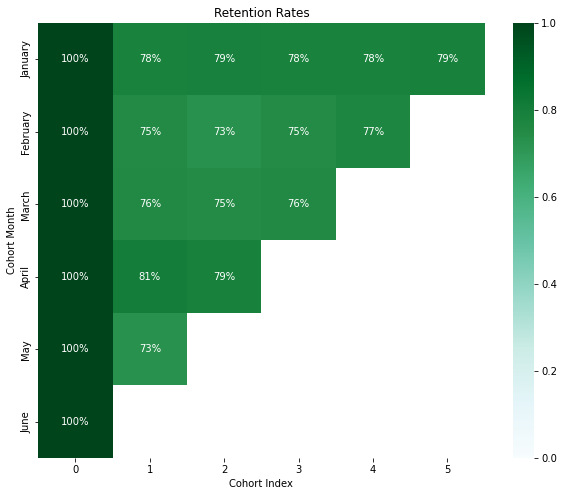

In [35]:
retention_rates = plt.figure(figsize=(10,8))
plt.title('Retention Rates')
sns.heatmap(data = retention,
            annot = True,
            fmt = '.0%',
            vmin = 0.0,
            vmax = 1,
            cmap = 'BuGn')
plt.show()

In [36]:
retention_rates.savefig("213524-Llenado_Customer Retention Rates.png", dpi=200)

## Correlation Heatmap

Text(0.5, 1.0, 'Correlation Heatmap')

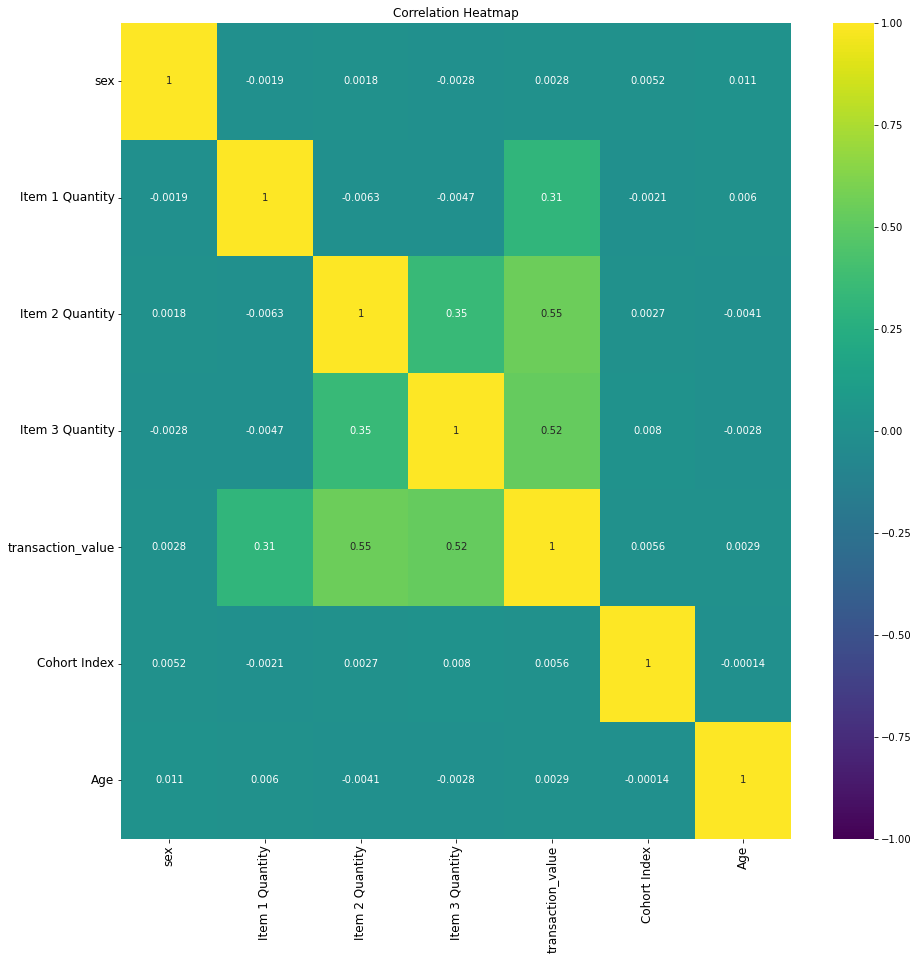

In [18]:
def age(born):
    born = datetime.strptime(born, "%Y/%m/%d").date()
    today = date.today()
    return today.year - born.year - ((today.month, 
                                      today.day) < (born.month, 
                                                    born.day))
  
df_clean['Age'] = df_clean['birthdate'].apply(age)
df_clean['sex'].replace('F', 0,inplace=True)
df_clean['sex'].replace('M', 1,inplace=True)

# generated correlation data
df_clean.shape
df_clean.describe()
df_clean.corr()

# generated the graph
correlation_heatmap = plt.figure(figsize = (15,15))
s = sns.heatmap(df_clean.corr(),
                annot = True,
                cmap = 'viridis',
                vmin = -1,
                vmax = 1)
s.set_yticklabels(s.get_yticklabels(), rotation = 0, fontsize = 12)
s.set_xticklabels(s.get_xticklabels(), rotation = 90, fontsize = 12)
plt.title('Correlation Heatmap')

In [19]:
correlation_heatmap.savefig("213524-Llenado_Customer Retention Rates.png")